In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import GlobalAveragePooling2D,Dropout,BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize

In [5]:

def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [6]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [7]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def initiateModel1(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(modelInput.output)
    #x = Dropout(0.2)(x)
    #x = Dense(128, activation='relu')(x)
    #x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)
    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [8]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
    ]
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=METRICS)
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'MobileNet.keras', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint



In [9]:
def modelFit(model, annealer, checkpoint):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=gEpochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [10]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [11]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[7]*100
    TP = evl[1]
    FP = evl[2]
    FN = evl[4]
    TN = evl[3]
    prec = evl[5]
    rec = evl[6]
    F1 = 100 * ((2 * prec * rec) / (prec + rec))
    auc = evl[8]
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    msg+=f'\nTrue Positives = {TP}. True Negatives = {TN}'
    msg+=f'\nFalse Positives = {FP}. False Negatives = {FN}'
    msg+=f'\nPrecision = {prec}'
    msg+=f'\nRecall = {rec}'
    msg+=f'\nF1 Score = {F1}'
    msg+=f'\nROC AUC = {auc}'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - MobileNetV3.keras")
    print("Model Saved!")

In [12]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [13]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")
    def objective_function(hyperparameters):
        lr,batch = hyperparameters
        accuracy = accuracy_score(y_true,y_pred)
        return -accuracy
    
    accuracy = accuracy_score(y_true, y_pred)
    search_space = [(1e-4, 1e-2), (32, 256)]
    result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')
    best_hyperparameters = result.x
    print("Best Hyperparameters (learning rate, batch size):", best_hyperparameters)

In [14]:
mpath = r'/kaggle/input/multi-cancer/Multi Cancer'
classPaths = os.listdir(mpath)
IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 10
batchSize = 256
lr = 0.001

for i in classPaths:
    print(i)
    

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
4334752/4334752 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)             

I0000 00:00:1711792400.716449     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - ETA: 0s - loss: 0.4924 - tp: 15140.0000 - fp: 1480.0000 - tn: 78520.0000 - fn: 4860.0000 - precision: 0.9110 - recall: 0.7570 - accuracy: 0.8368 - auc: 0.9741
Epoch 1: val_loss improved from inf to 0.27576, saving model to Cervical Cancer MobileNet.keras
625/625 [==============================] - 232s 360ms/step - loss: 0.4924 - tp: 15140.0000 - fp: 1480.0000 - tn: 78520.0000 - fn: 4860.0000 - precision: 0.9110 - recall: 0.7570 - accuracy: 0.8368 - auc: 0.9741 - val_loss: 0.2758 - val_tp: 4437.0000 - val_fp: 258.0000 - val_tn: 19742.0000 - val_fn: 563.0000 - val_precision: 0.9450 - val_recall: 0.8874 - val_accuracy: 0.9166 - val_auc: 0.9930 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.2356 - tp: 18070.0000 - fp: 1018.0000 - tn: 78982.0000 - fn: 1930.0000 - precision: 0.9467 - recall: 0.9035 - accuracy: 0.9269 - auc: 0.9945
Epoch 2: val_loss improved from 0.27576 to 0.18892, saving model to Cervical Cance

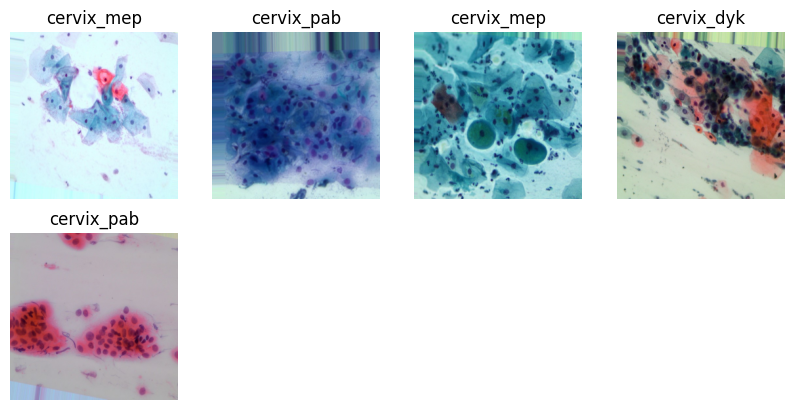

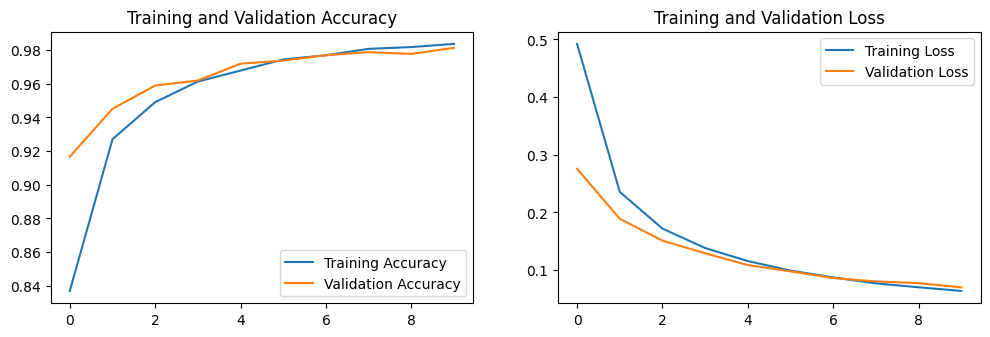

157/157 [==============================] - 16s 103ms/step - loss: 0.0702 - tp: 4890.0000 - fp: 81.0000 - tn: 19919.0000 - fn: 110.0000 - precision: 0.9837 - recall: 0.9780 - accuracy: 0.9812 - auc: 0.9996
Accuracy on the Test Set = 98.12 %
True Positives = 4890.0. True Negatives = 19919.0
False Positives = 81.0. False Negatives = 110.0
Precision = 0.9837055206298828
Recall = 0.9779999852180481
F1 Score = 98.08444557727776
ROC AUC = 0.9995909333229065
Model Saved!
True :  [0 0 0 ... 4 4 4]
157/157 [==============================] - 17s 100ms/step
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 640x480 with 0 Axes>

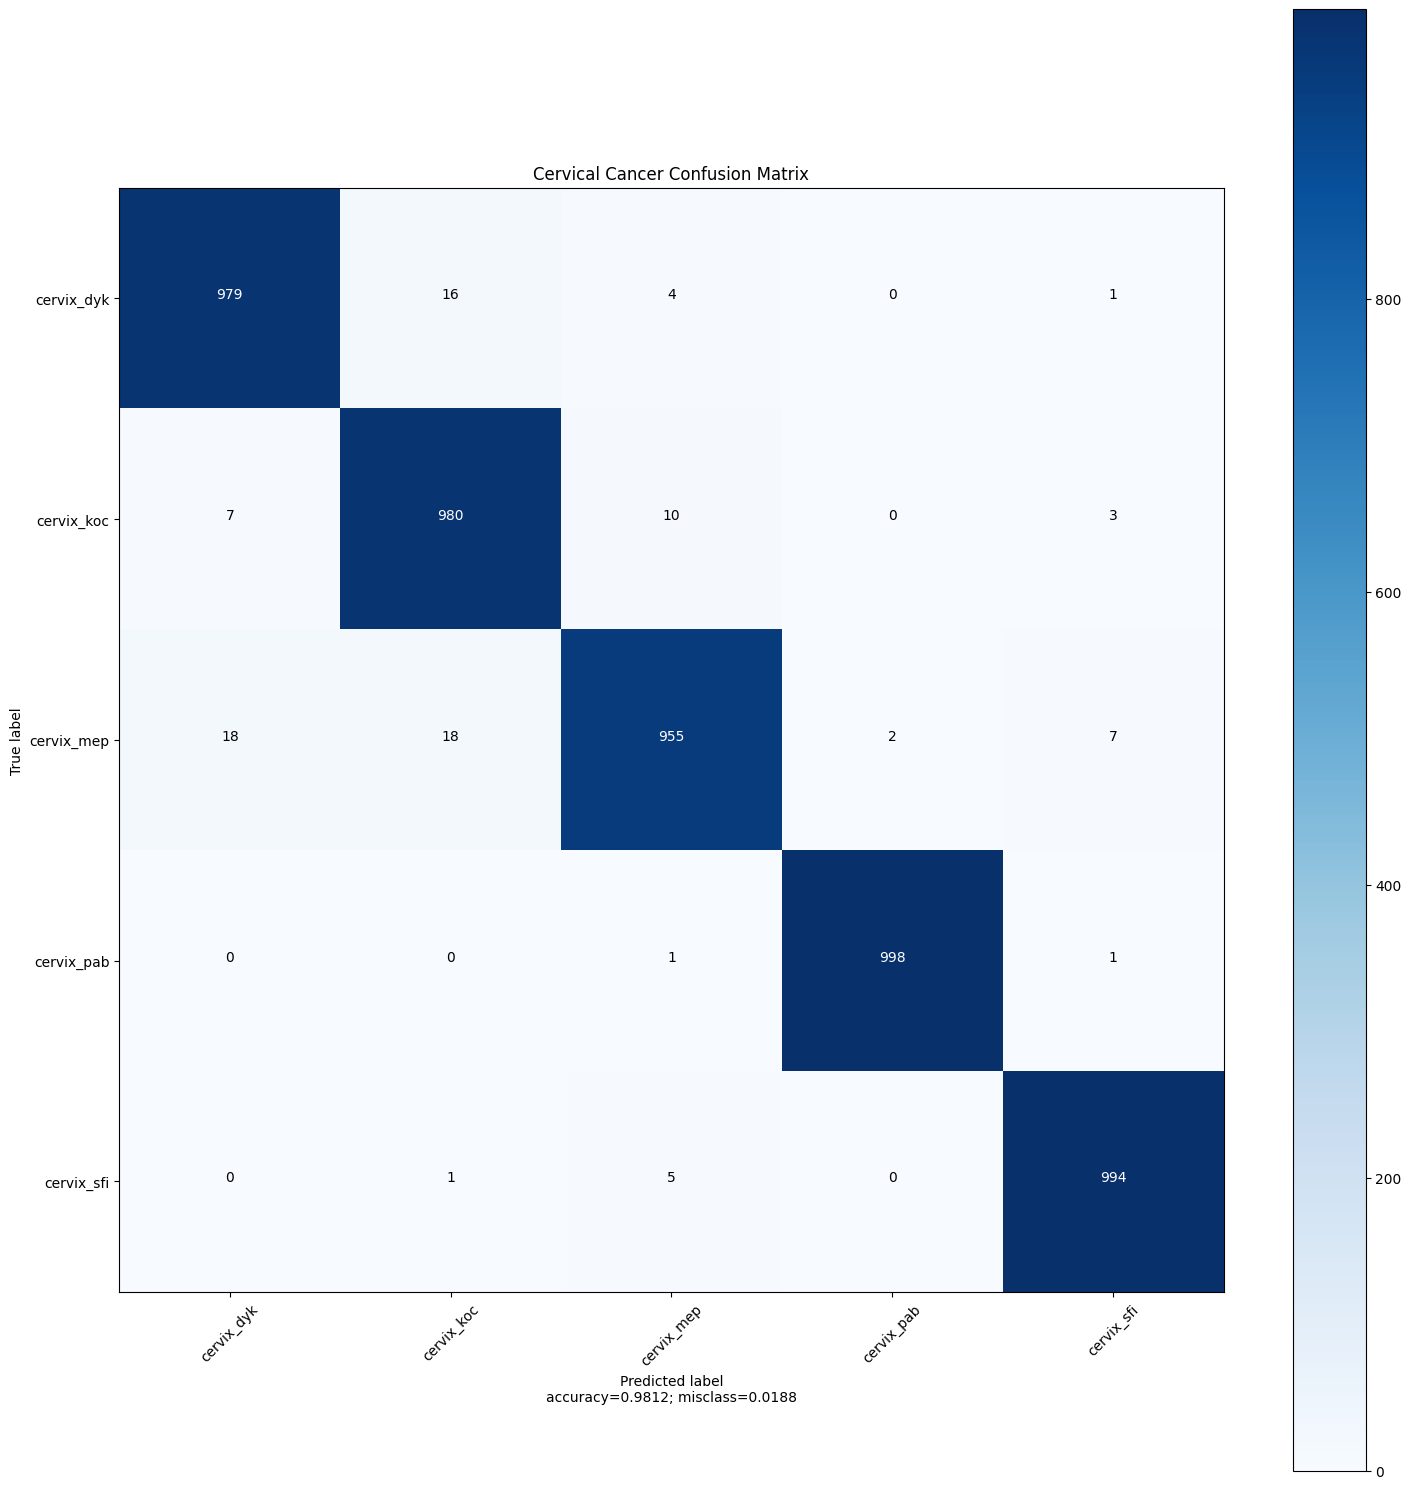

Best Hyperparameters (learning rate, batch size): [9.95285188e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [15]:
className = 'Cervical Cancer '
cpath = os.path.join(mpath, 'Cervical Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_1[0][0]']       

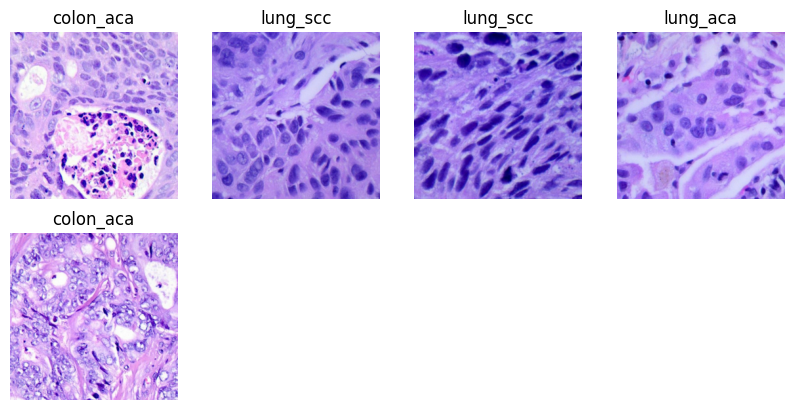

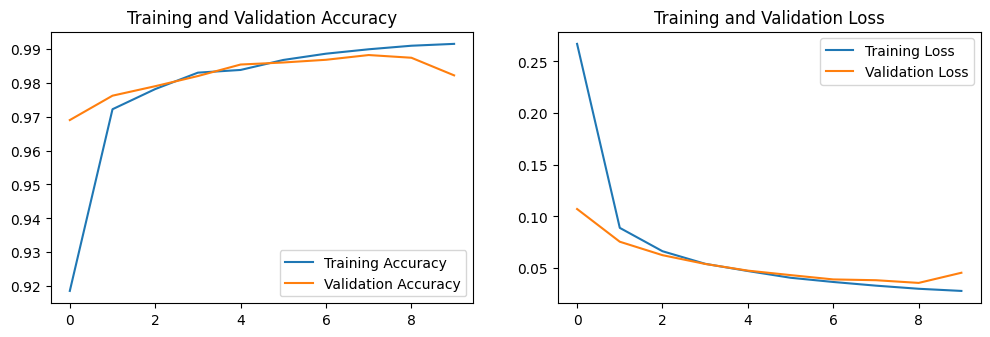

157/157 [==============================] - 17s 105ms/step - loss: 0.0455 - tp: 4910.0000 - fp: 89.0000 - tn: 19911.0000 - fn: 90.0000 - precision: 0.9822 - recall: 0.9820 - accuracy: 0.9822 - auc: 0.9997
Accuracy on the Test Set = 98.22 %
True Positives = 4910.0. True Negatives = 19911.0
False Positives = 89.0. False Negatives = 90.0
Precision = 0.9821964502334595
Recall = 0.9819999933242798
F1 Score = 98.20982119541605
ROC AUC = 0.9997036457061768
Model Saved!
True :  [0 0 0 ... 4 4 4]
157/157 [==============================] - 18s 108ms/step
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 640x480 with 0 Axes>

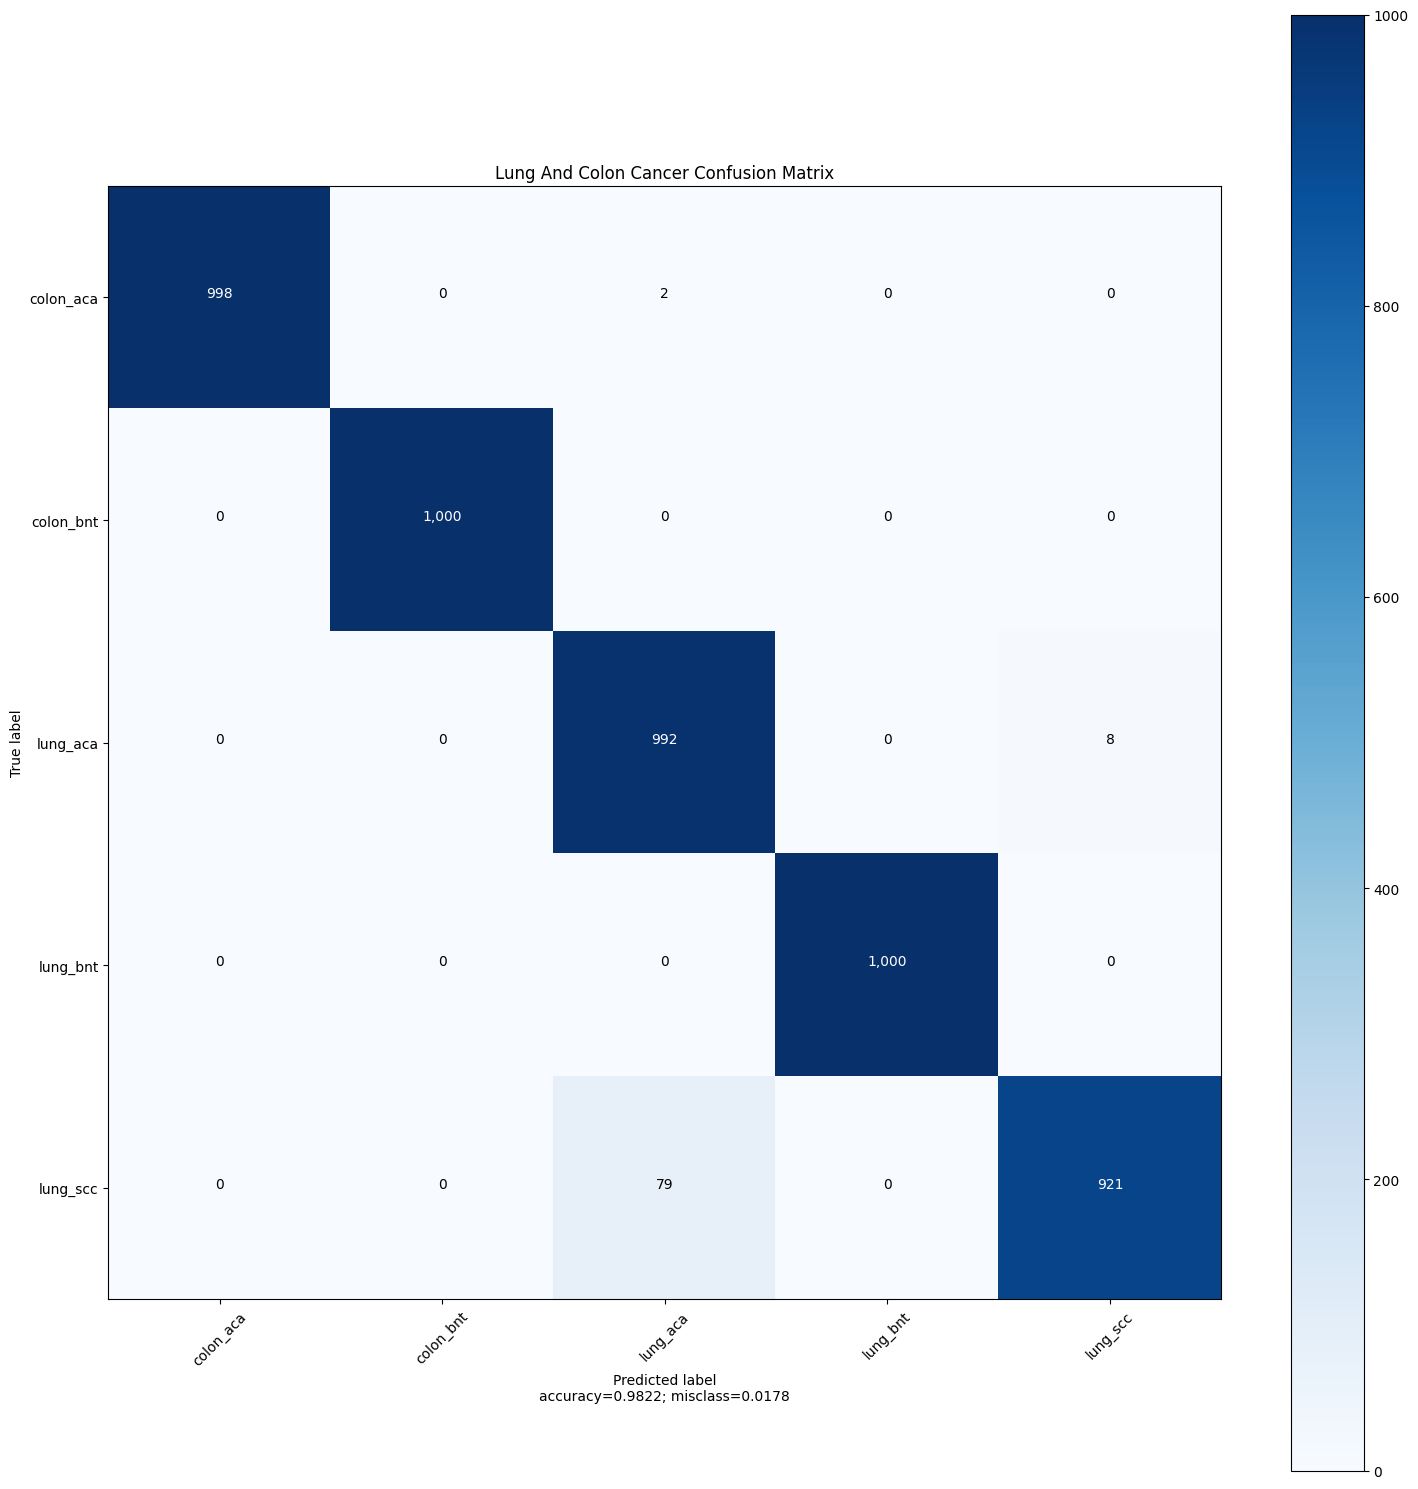

Best Hyperparameters (learning rate, batch size): [9.95284101e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [16]:
className = 'Lung And Colon Cancer '
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 8002 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_2[0][0]']         
                                 

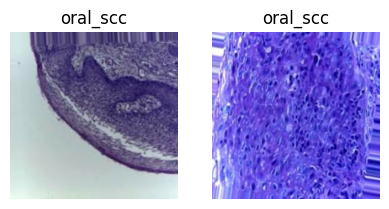

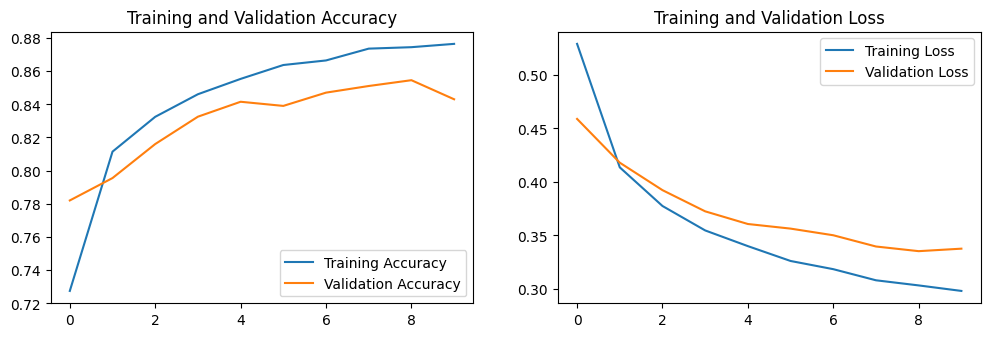

63/63 [==============================] - 6s 102ms/step - loss: 0.3374 - tp: 1686.0000 - fp: 314.0000 - tn: 1686.0000 - fn: 314.0000 - precision: 0.8430 - recall: 0.8430 - accuracy: 0.8430 - auc: 0.9298
Accuracy on the Test Set = 84.30 %
True Positives = 1686.0. True Negatives = 1686.0
False Positives = 314.0. False Negatives = 314.0
Precision = 0.8429999947547913
Recall = 0.8429999947547913
F1 Score = 84.29999947547913
ROC AUC = 0.9298345446586609
Model Saved!
True :  [0 0 0 ... 1 1 1]
63/63 [==============================] - 7s 100ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

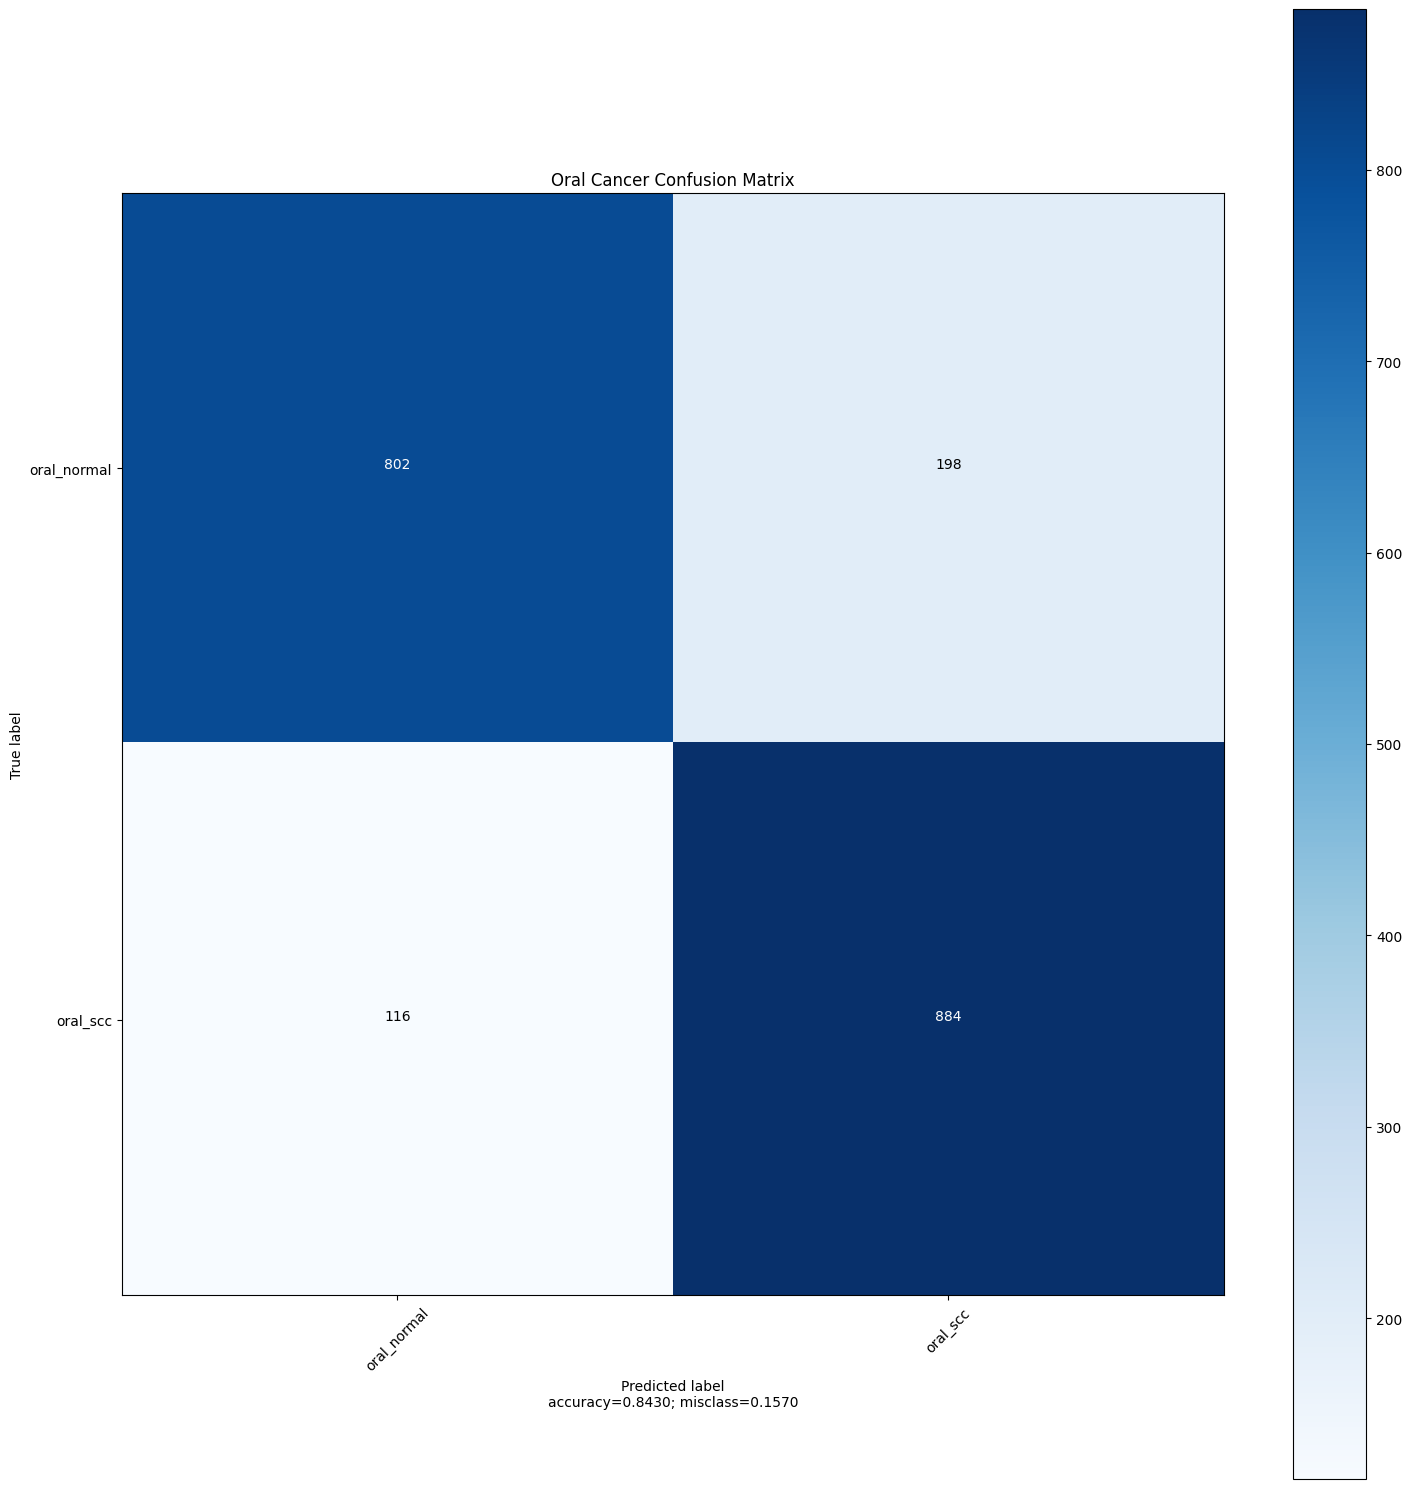

Best Hyperparameters (learning rate, batch size): [9.95284038e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [17]:
className = 'Oral Cancer '
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 16000 images belonging to 4 classes.

For Val :  Found 4000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_3[0][0]']         
          

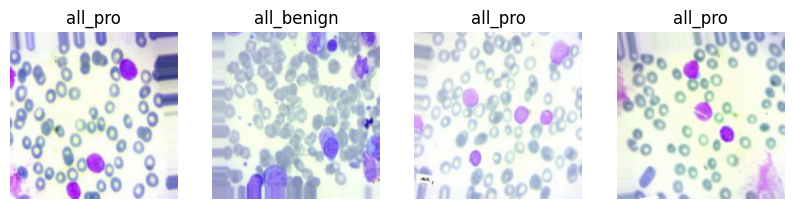

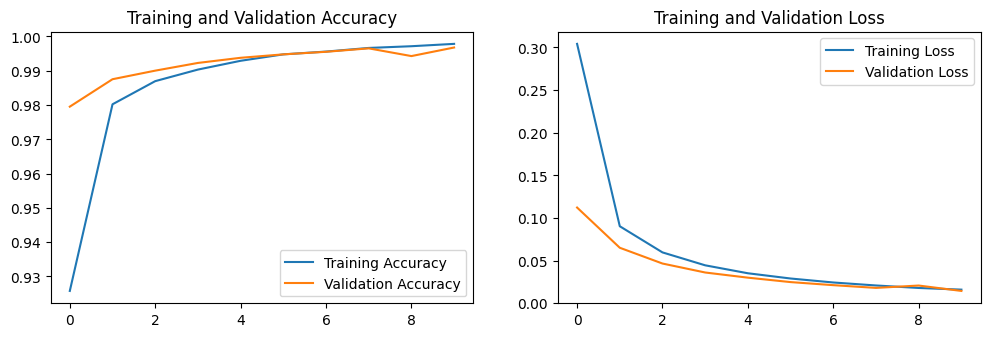

125/125 [==============================] - 12s 94ms/step - loss: 0.0143 - tp: 3987.0000 - fp: 11.0000 - tn: 11989.0000 - fn: 13.0000 - precision: 0.9972 - recall: 0.9967 - accuracy: 0.9967 - auc: 1.0000
Accuracy on the Test Set = 99.67 %
True Positives = 3987.0. True Negatives = 11989.0
False Positives = 11.0. False Negatives = 13.0
Precision = 0.997248649597168
Recall = 0.996749997138977
F1 Score = 99.69992610174097
ROC AUC = 0.9999866485595703
Model Saved!
True :  [0 0 0 ... 3 3 3]
125/125 [==============================] - 13s 94ms/step
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 640x480 with 0 Axes>

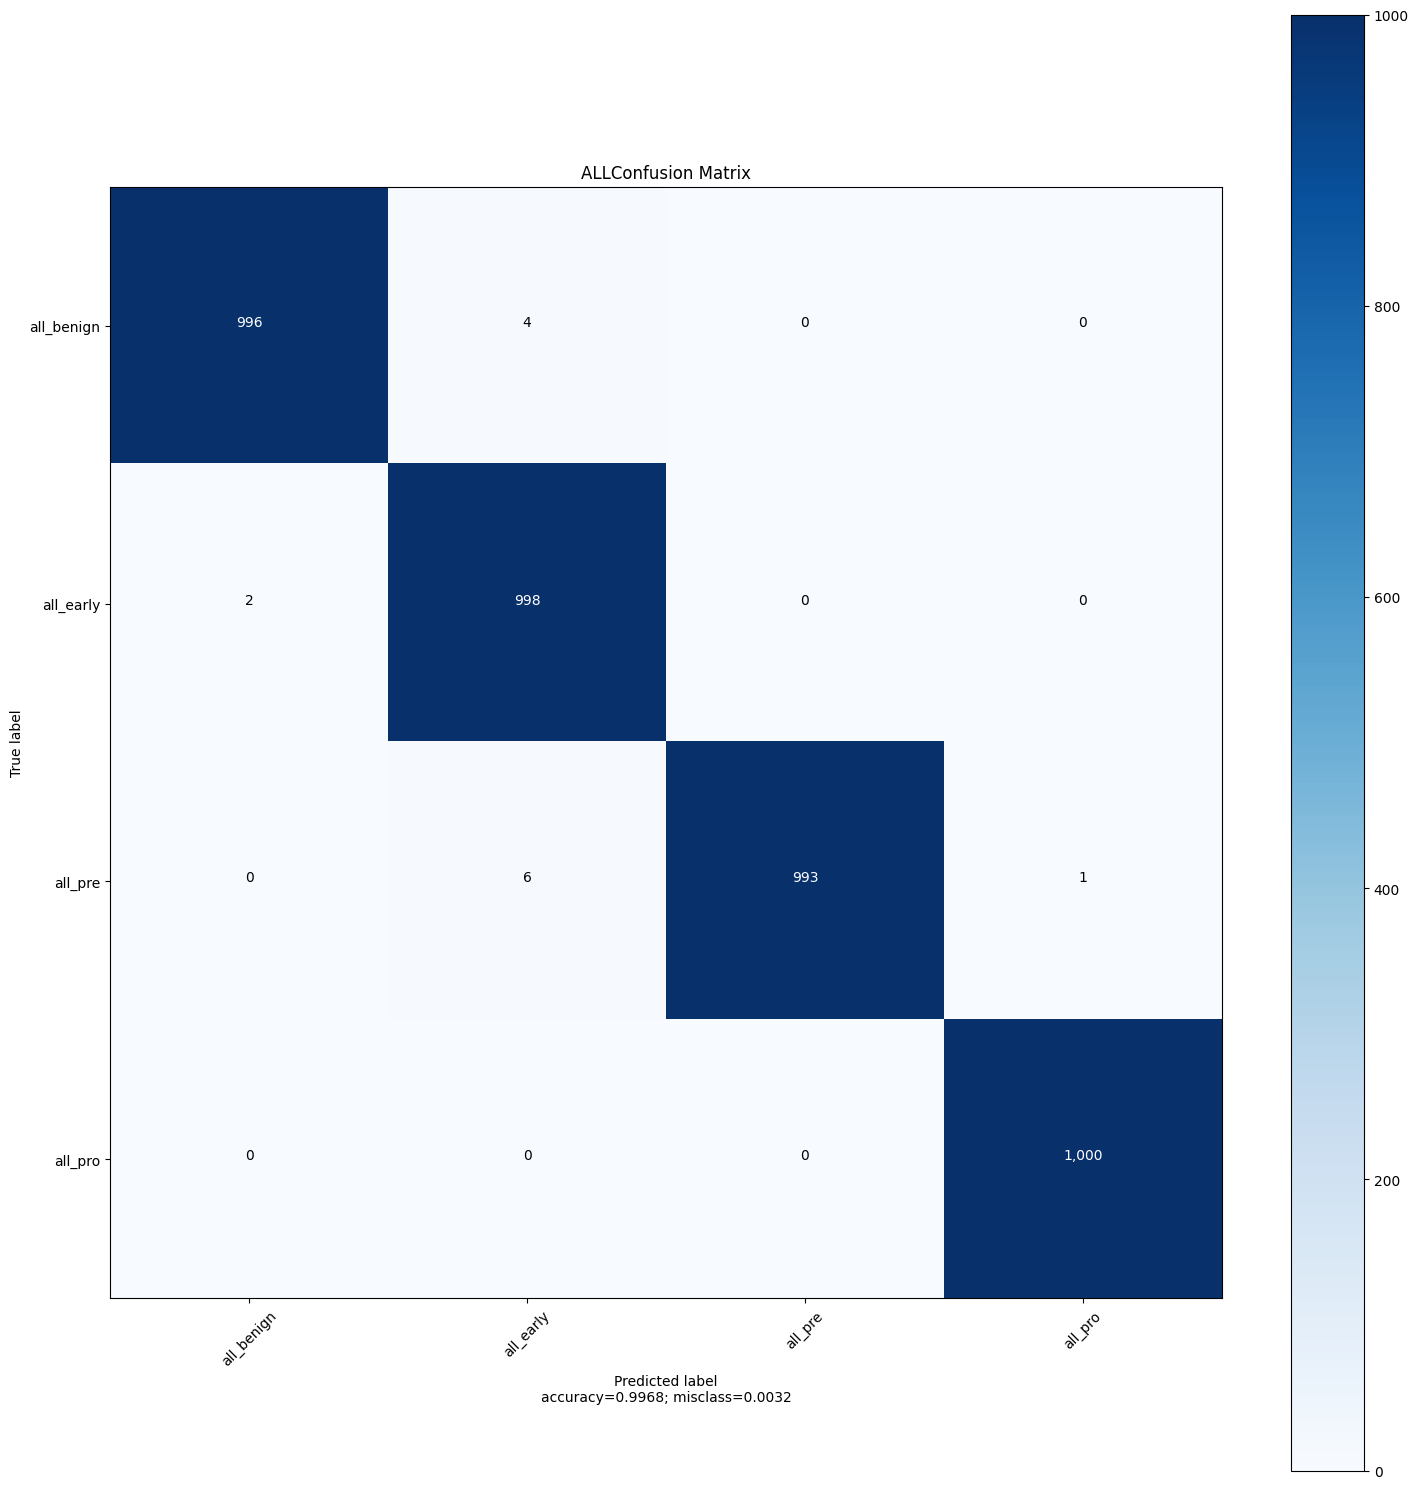

Best Hyperparameters (learning rate, batch size): [9.95284192e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [18]:
className = 'ALL'
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_4[0][0]']         
                           

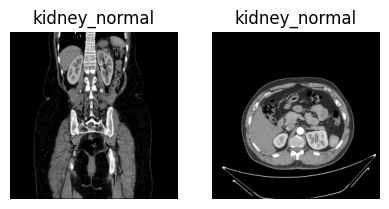

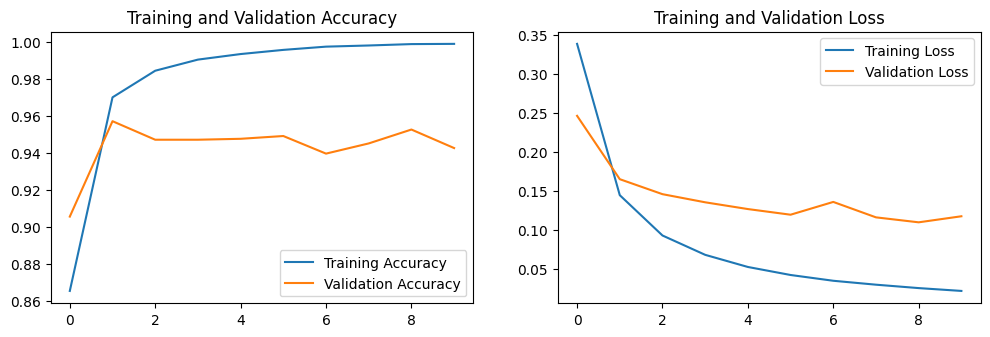

63/63 [==============================] - 6s 94ms/step - loss: 0.1173 - tp: 1885.0000 - fp: 115.0000 - tn: 1885.0000 - fn: 115.0000 - precision: 0.9425 - recall: 0.9425 - accuracy: 0.9425 - auc: 0.9921
Accuracy on the Test Set = 94.25 %
True Positives = 1885.0. True Negatives = 1885.0
False Positives = 115.0. False Negatives = 115.0
Precision = 0.9424999952316284
Recall = 0.9424999952316284
F1 Score = 94.24999952316284
ROC AUC = 0.9921355247497559
Model Saved!
True :  [0 0 0 ... 1 1 1]
63/63 [==============================] - 7s 97ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

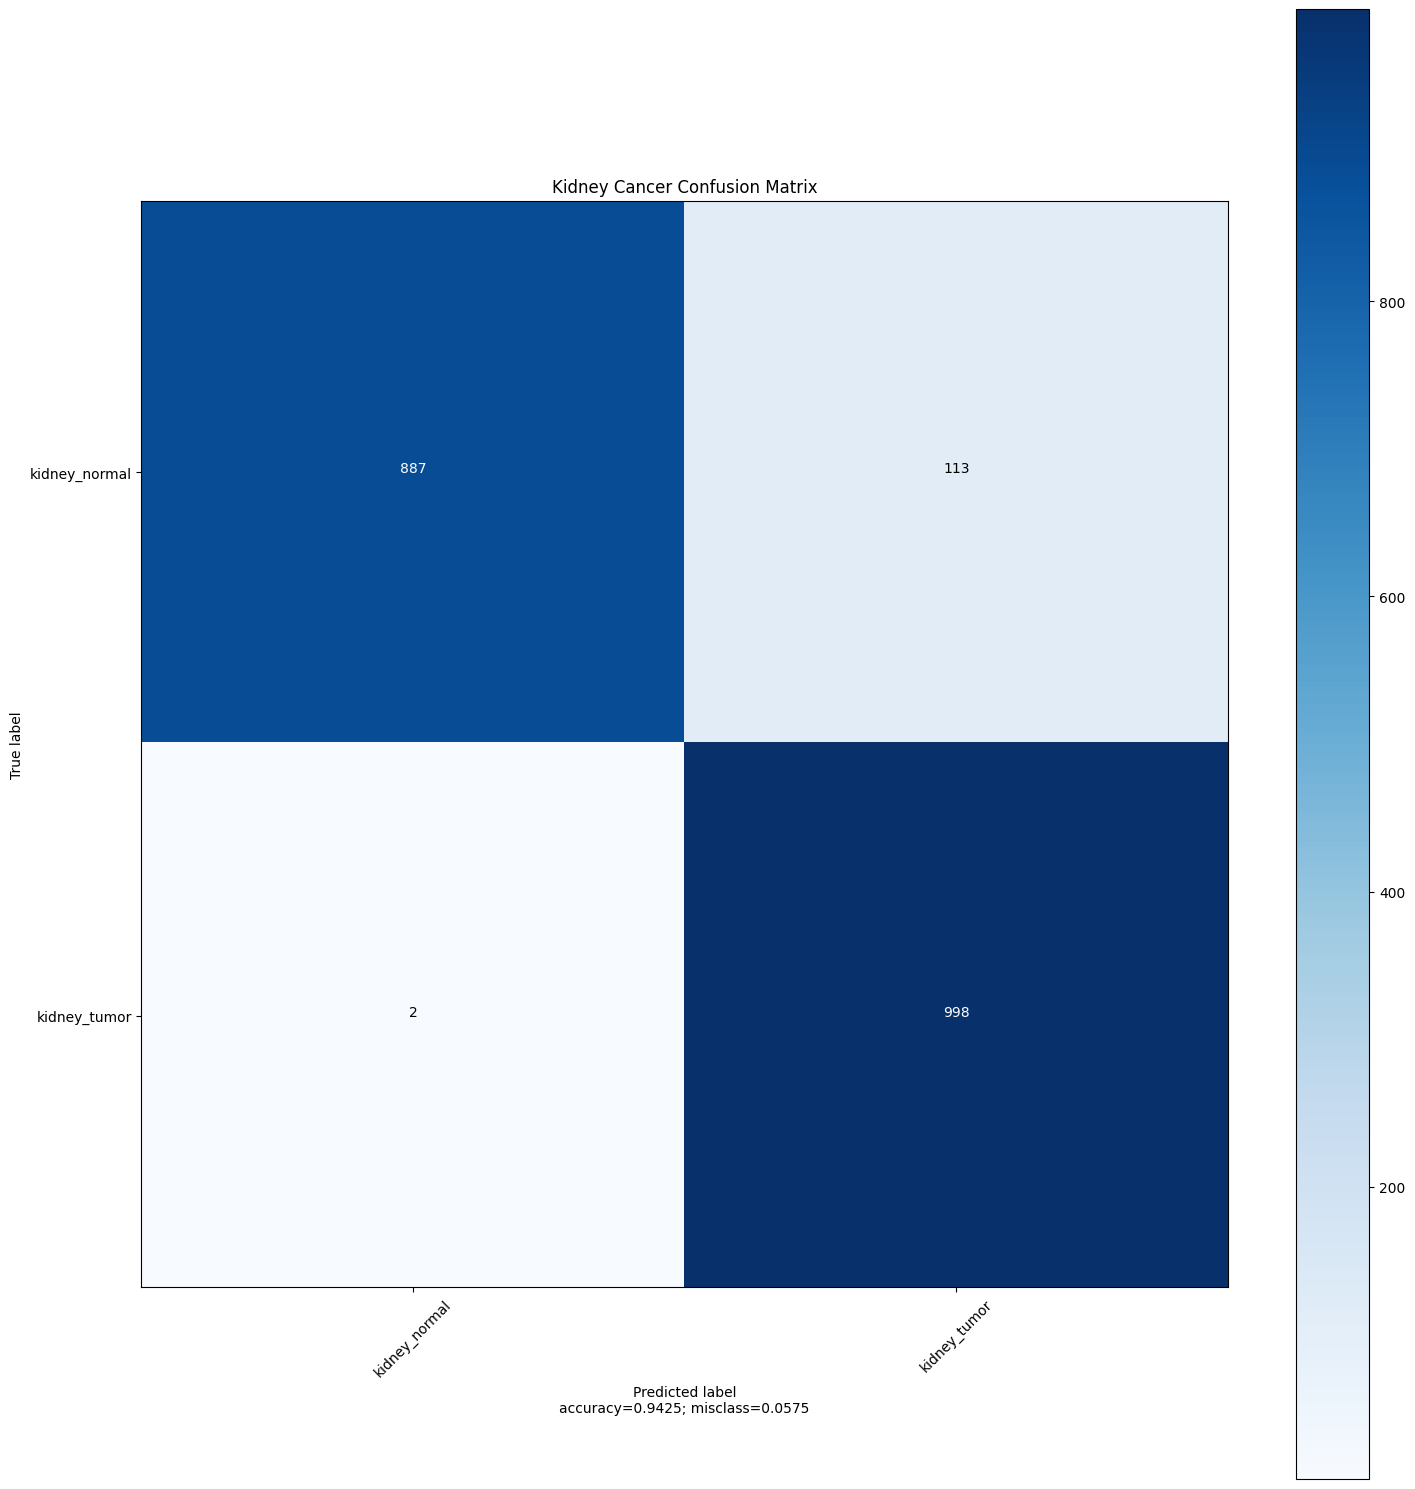

Best Hyperparameters (learning rate, batch size): [9.95285412e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [19]:
className = 'Kidney Cancer '
cpath = os.path.join(mpath, 'Kidney Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_5[0][0]']         
                       

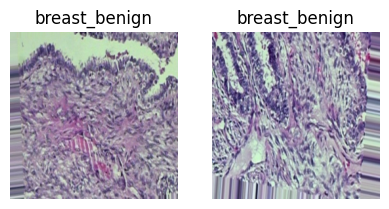

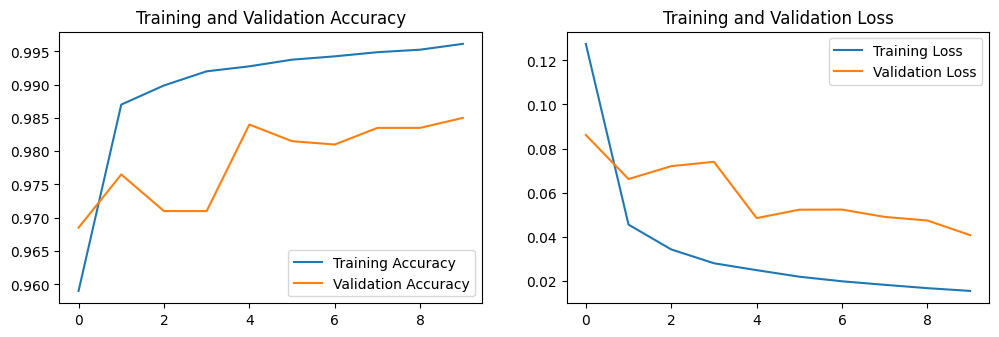

63/63 [==============================] - 14s 230ms/step - loss: 0.0407 - tp: 1970.0000 - fp: 30.0000 - tn: 1970.0000 - fn: 30.0000 - precision: 0.9850 - recall: 0.9850 - accuracy: 0.9850 - auc: 0.9986
Accuracy on the Test Set = 98.50 %
True Positives = 1970.0. True Negatives = 1970.0
False Positives = 30.0. False Negatives = 30.0
Precision = 0.9850000143051147
Recall = 0.9850000143051147
F1 Score = 98.50000143051147
ROC AUC = 0.9985750913619995
Model Saved!
True :  [0 0 0 ... 1 1 1]
63/63 [==============================] - 15s 220ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

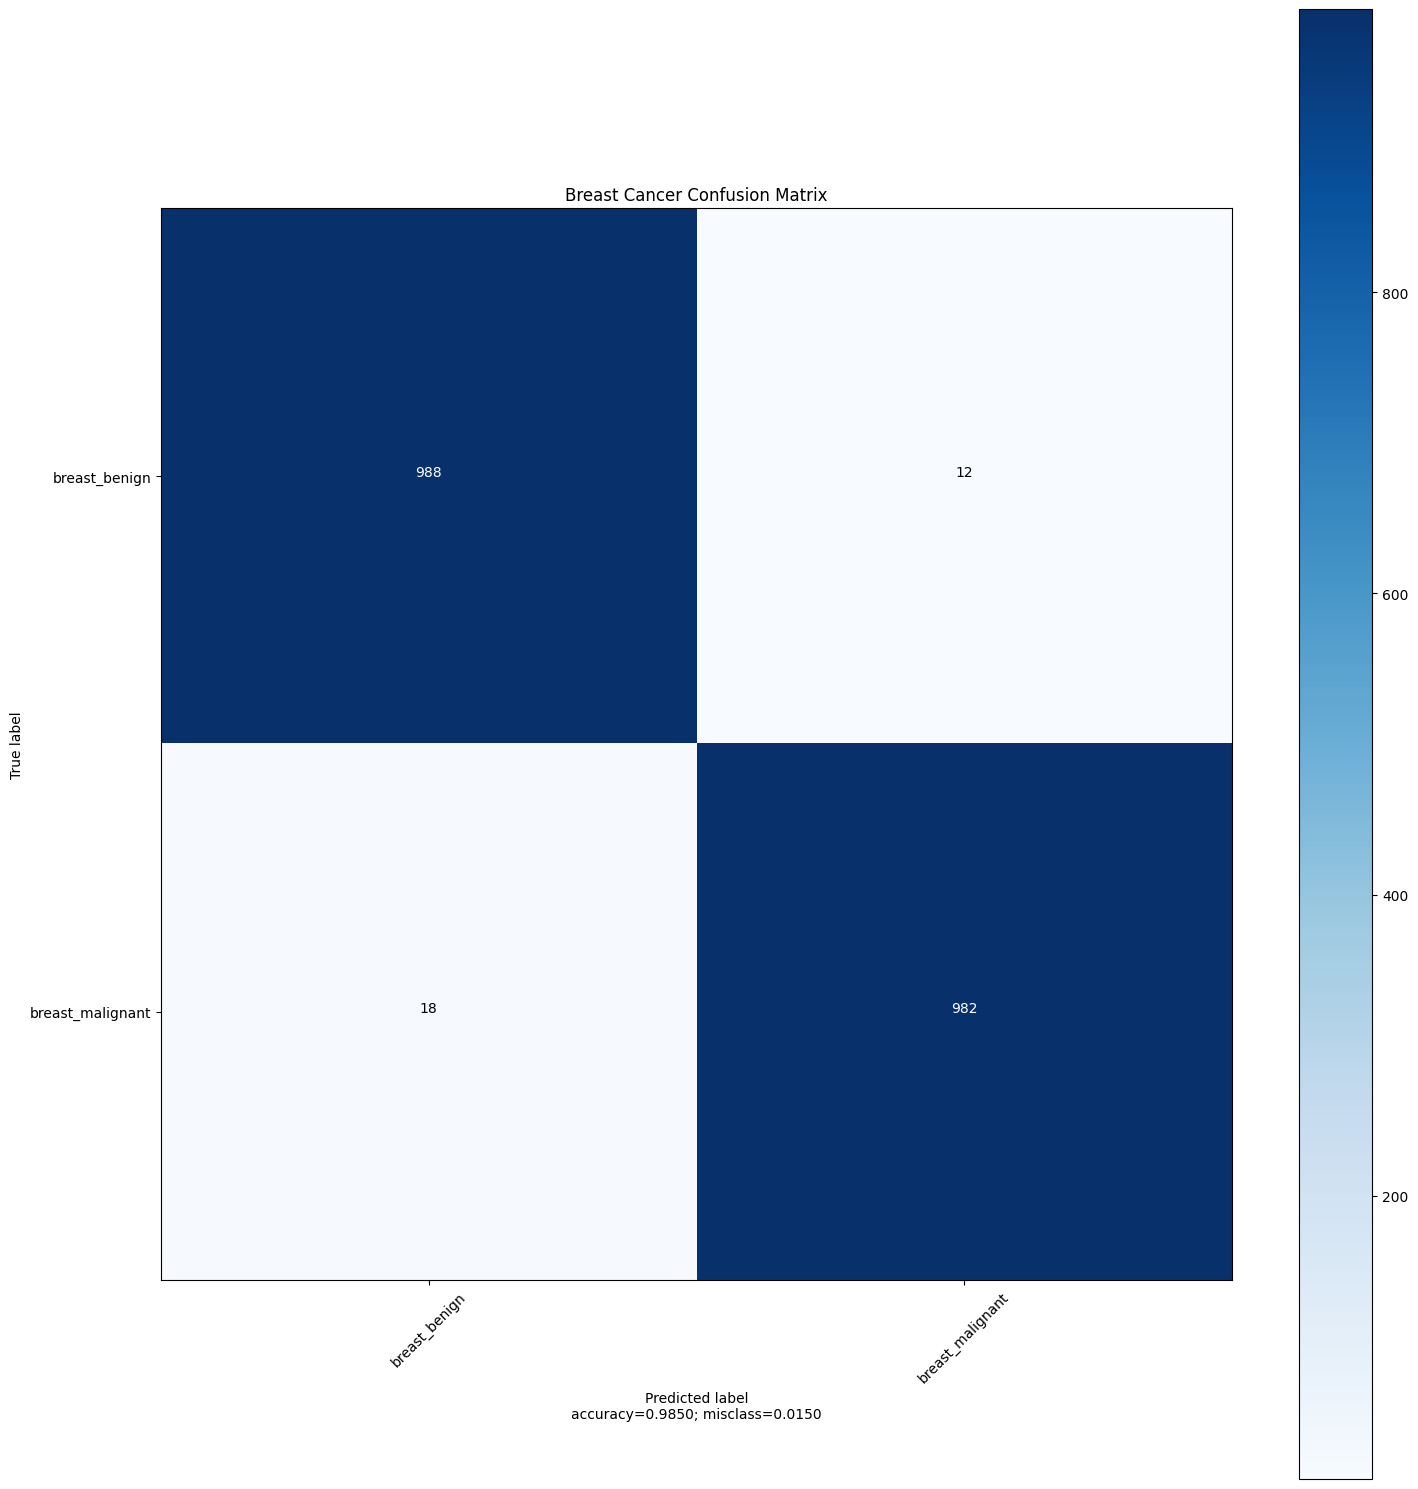

Best Hyperparameters (learning rate, batch size): [9.95285259e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [20]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['input_7[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_6[0][0]']         
                     

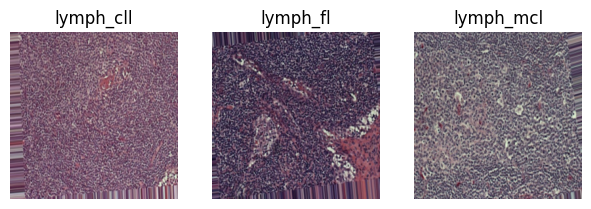

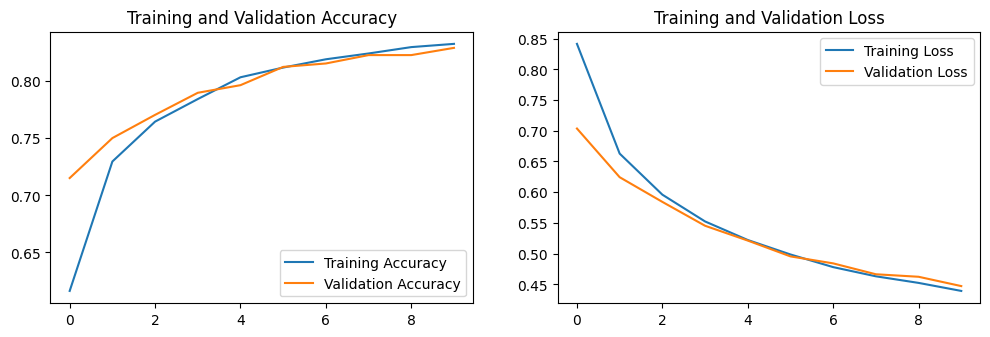

94/94 [==============================] - 12s 125ms/step - loss: 0.4469 - tp: 2389.0000 - fp: 405.0000 - tn: 5595.0000 - fn: 611.0000 - precision: 0.8550 - recall: 0.7963 - accuracy: 0.8290 - auc: 0.9491
Accuracy on the Test Set = 82.90 %
True Positives = 2389.0. True Negatives = 5595.0
False Positives = 405.0. False Negatives = 611.0
Precision = 0.8550465106964111
Recall = 0.7963333129882812
F1 Score = 82.4646166625264
ROC AUC = 0.9490994215011597
Model Saved!
True :  [0 0 0 ... 2 2 2]
94/94 [==============================] - 13s 127ms/step
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 640x480 with 0 Axes>

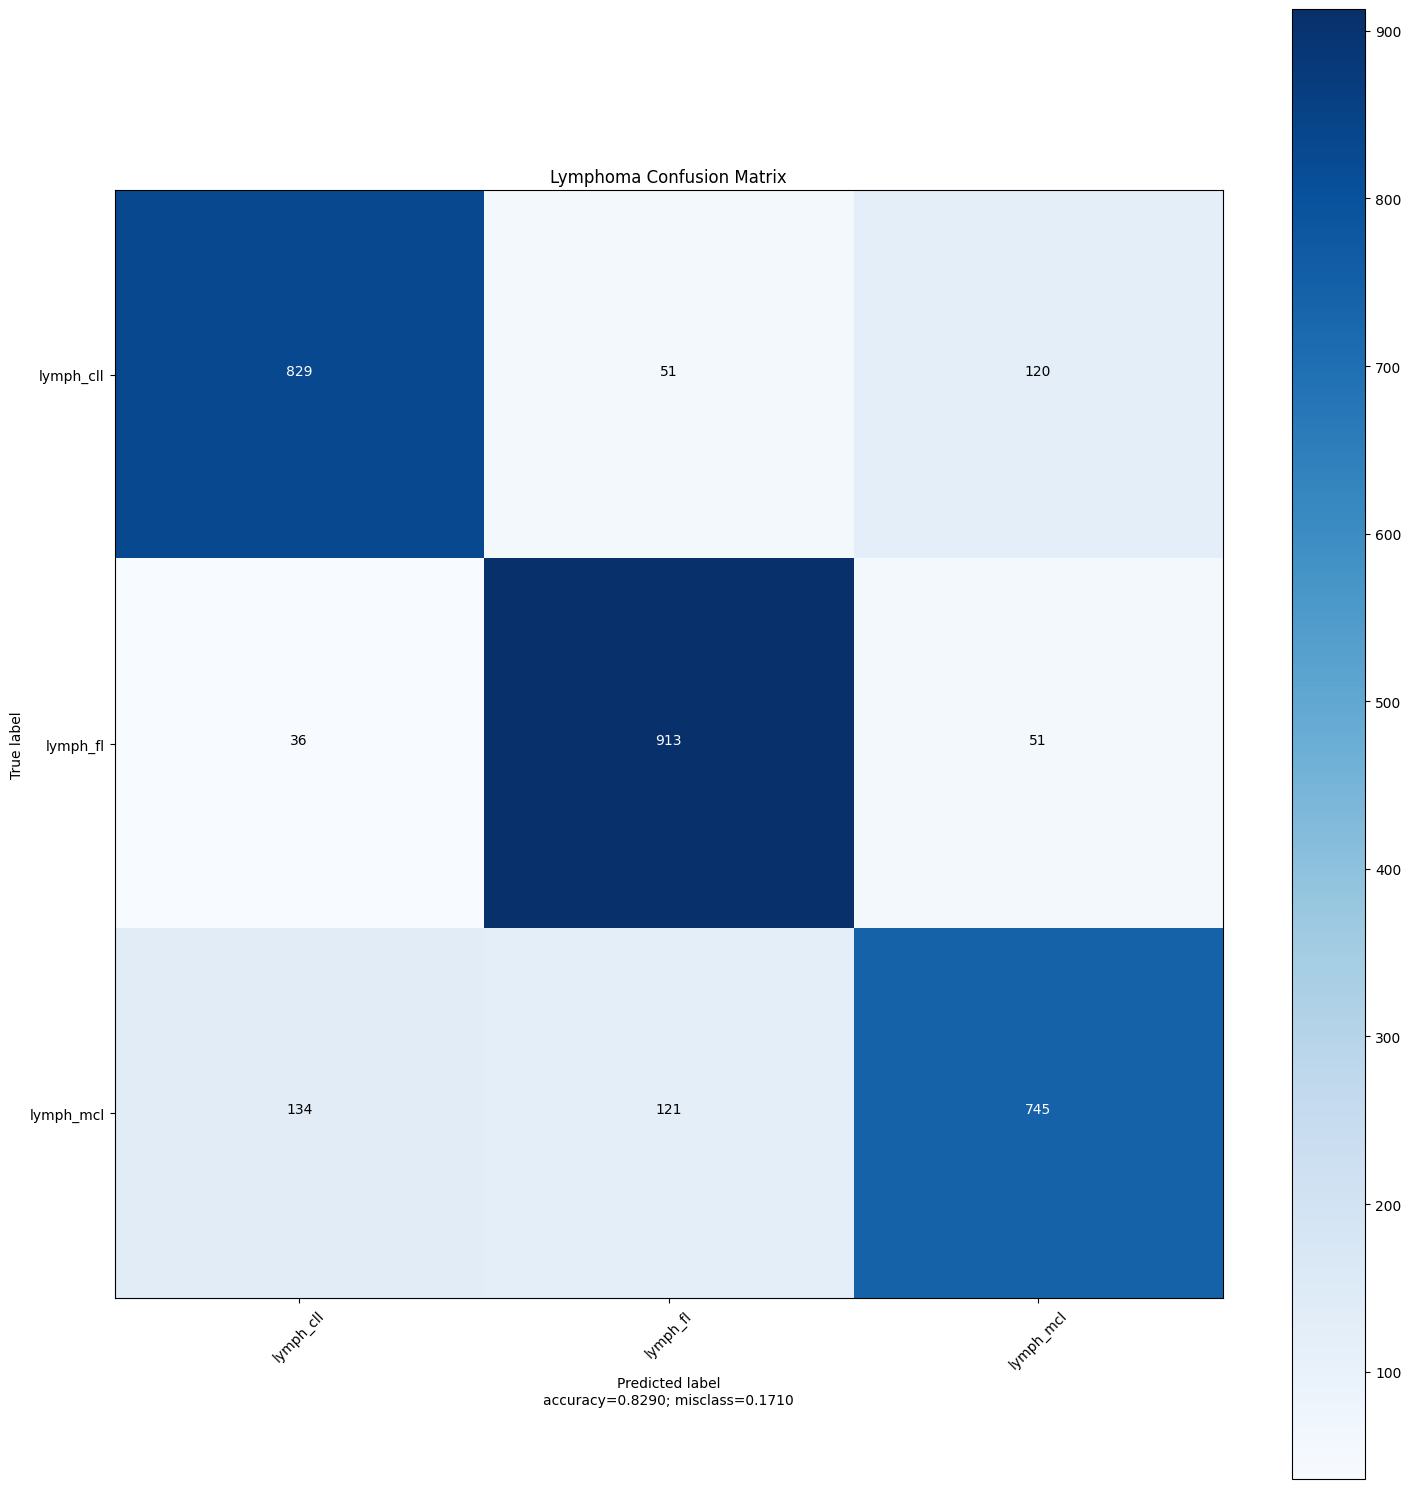

Best Hyperparameters (learning rate, batch size): [9.95284692e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [21]:
className = 'Lymphoma '
cpath = os.path.join(mpath, 'Lymphoma')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['input_8[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_7[0][0]']         
             

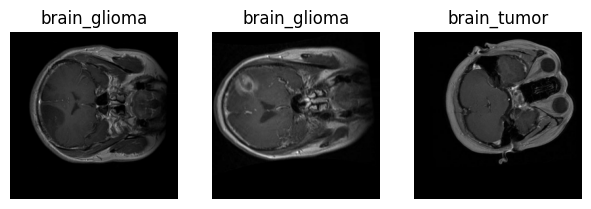

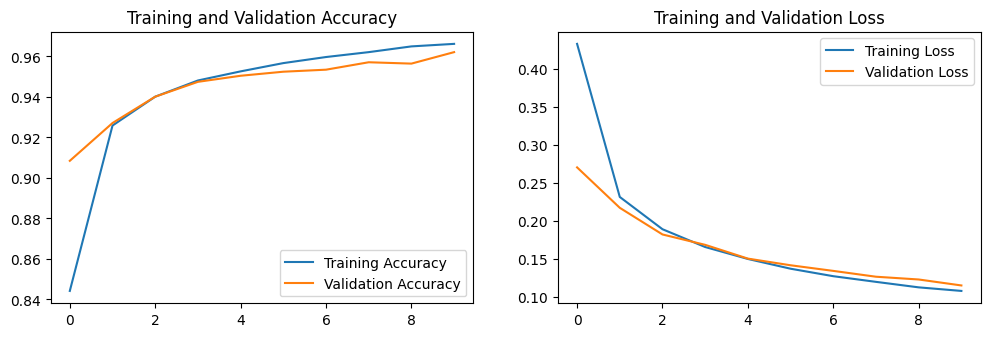

94/94 [==============================] - 8s 86ms/step - loss: 0.1150 - tp: 2882.0000 - fp: 108.0000 - tn: 5892.0000 - fn: 118.0000 - precision: 0.9639 - recall: 0.9607 - accuracy: 0.9620 - auc: 0.9964
Accuracy on the Test Set = 96.20 %
True Positives = 2882.0. True Negatives = 5892.0
False Positives = 108.0. False Negatives = 118.0
Precision = 0.9638795852661133
Recall = 0.9606666564941406
F1 Score = 96.22704389722908
ROC AUC = 0.9964373111724854
Model Saved!
True :  [0 0 0 ... 2 2 2]
94/94 [==============================] - 9s 84ms/step
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 640x480 with 0 Axes>

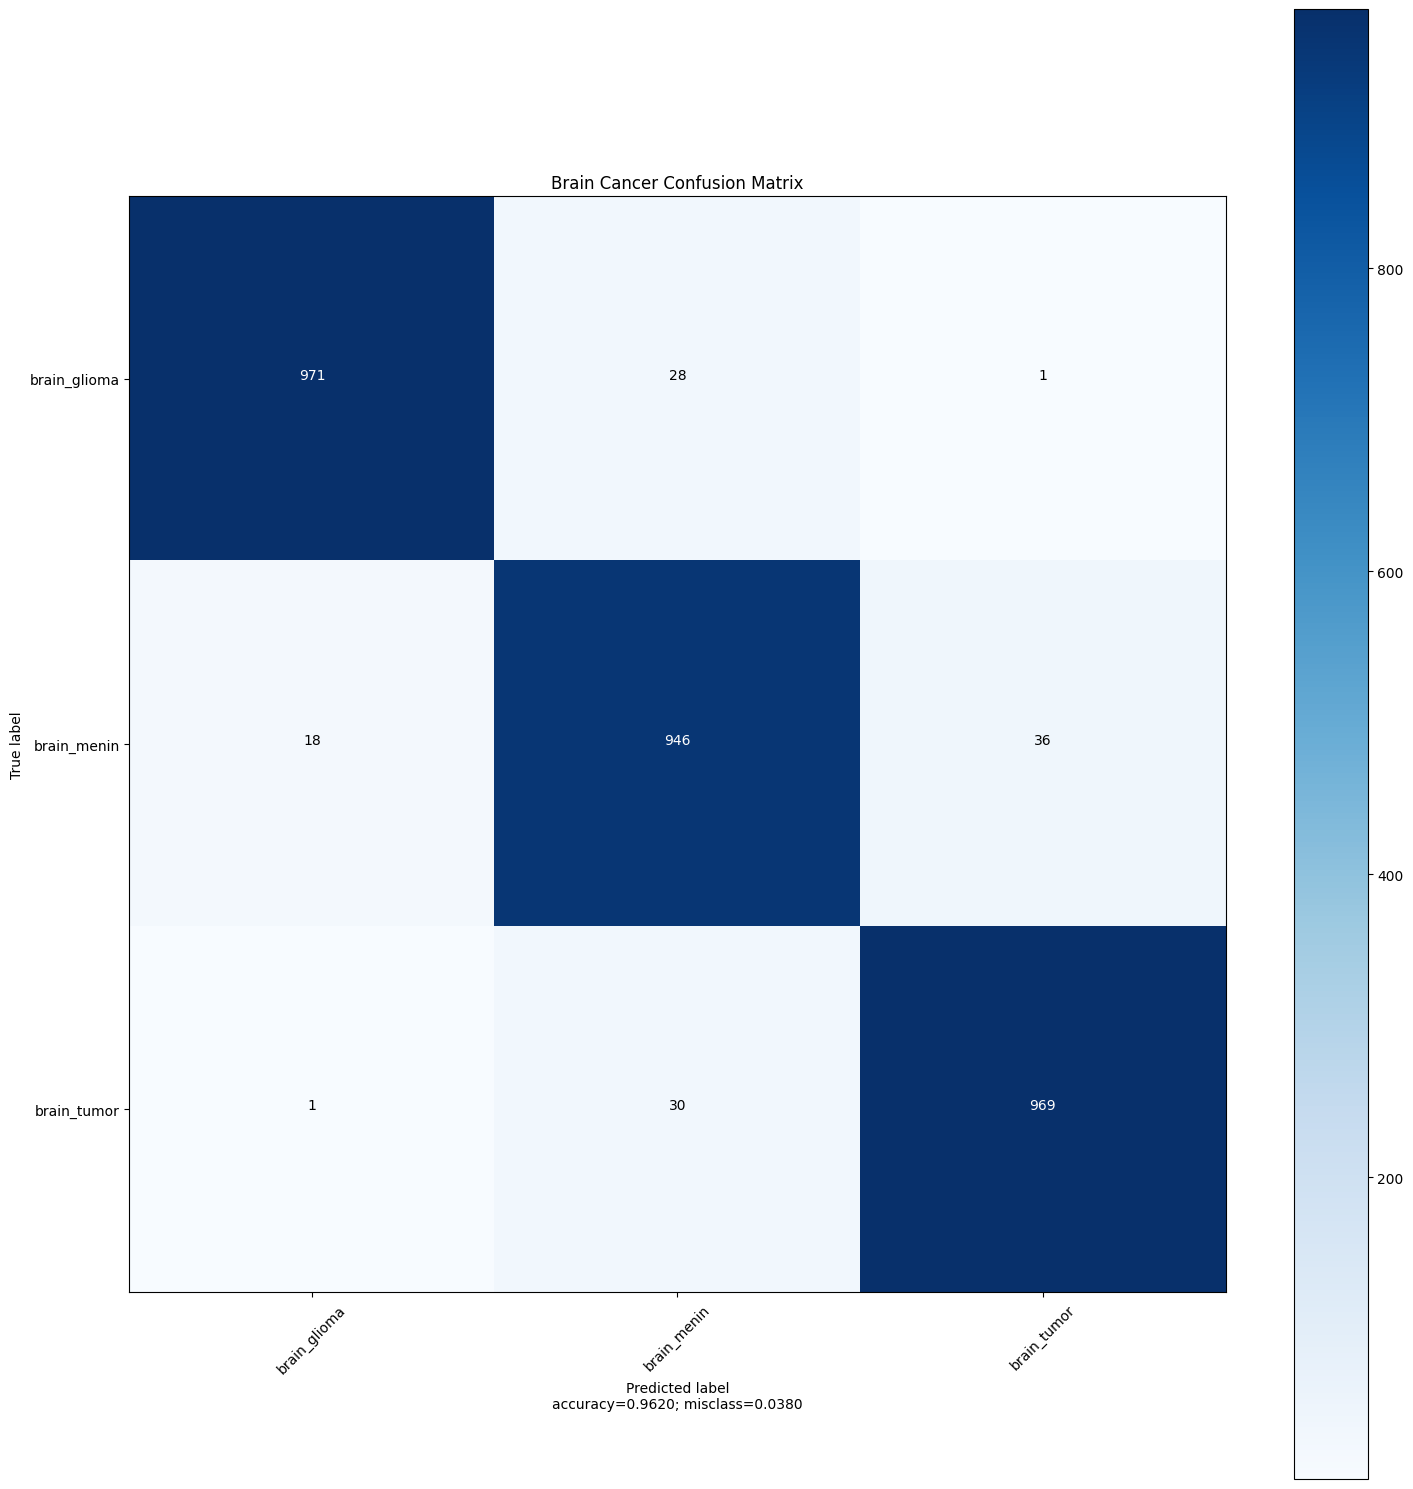

Best Hyperparameters (learning rate, batch size): [9.95284587e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [22]:
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel1(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)